In [137]:
import numpy as np
from glob import glob
from matplotlib import pyplot as plt

In [140]:
files = glob("coords/alldata03.epoch01*.npy")
files

['coords/alldata03.epoch01_test_drmsd.npy',
 'coords/alldata03.epoch01_test_ndrmsd.npy',
 'coords/alldata03.epoch01_train_drmsd.npy',
 'coords/alldata03.epoch01_train_ndrmsd.npy']

In [5]:
data = {"trans":{"train": {"nd":0, "d":0}, "test": {"nd":0, "d":0}},
        "rnn"  :{"train": {"nd":0, "d":0}, "test": {"nd":0, "d":0}}}
for i in files:

    if "test" in i:
        first = 'test'
    else:
        first = 'train'
    
    if 'ndrmsd' in i:
        sec = 'nd'
    else:
        sec = 'd'
        
    with open(i, "rb") as f:
        data["trans"][first][sec] = np.load(f)

data

{'trans': {'train': {'nd': array([ 8.122003 , 65.25426  , 11.964566 , ...,  7.5165944,  7.547029 ,
           6.3790336], dtype=float32),
   'd': array([11.289584,  6.525426,  8.375196, ..., 19.693478, 24.754255,
          24.495487], dtype=float32)},
  'test': {'nd': array([ 8.8426285,  5.4420867, 11.248397 , ..., 25.67211  ,  7.8025594,
           7.8752604], dtype=float32),
   'd': array([16.270437 , 11.591644 , 10.461009 , ...,  6.9314694, 14.278684 ,
          11.7341385], dtype=float32)}},
 'rnn': {'train': {'nd': 0, 'd': 0}, 'test': {'nd': 0, 'd': 0}}}

In [8]:
with open("/home/jok120/seq2struct/notebooks/structure/predictions_100118/drmsds.npy", "rb") as f:
    data["rnn"]["test"]["nd"] = np.load(f)

In [145]:
l = open("/home/jok120/Desktop/transformer_compare.log").read().splitlines()
l = np.array(list(map(float, l[:-1])))
l, len(l)

(array([11.198905 , 11.5315714, 10.7934227, ..., 22.3198471, 13.9560061,
        10.6293602]), 10752)

In [147]:
data["trans"]["test"]["d"]

array([16.270437 , 11.591644 , 10.461009 , ...,  6.9314694, 14.278684 ,
       11.7341385], dtype=float32)

In [146]:
data["rnn"]["test"]["d"] = l

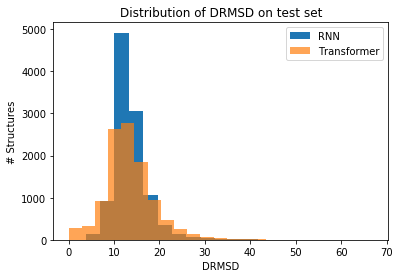

In [152]:
plt.hist(data["rnn"]["test"]["d"], label="RNN", bins=20)
plt.hist(data["trans"]["test"]["d"], alpha=0.7, label="Transformer", bins=20)
plt.xlabel("DRMSD")
plt.ylabel("# Structures")
plt.legend()
plt.title("Distribution of DRMSD loss on test set")
plt.savefig("transformer_vs_rnn_comparison.png", dpi=300)

In [149]:
print(data["rnn"]["test"]["d"].mean(), data["rnn"]["test"]["d"].std())
print(data["trans"]["test"]["d"].mean(), data["trans"]["test"]["d"].std())

13.665103790585007 4.134694921493334
13.495317 5.701053


In [153]:
def make_2_dist_plot(d1, d2, label1, label2, filename="loss_comparison.png", myset="test"):
    plt.hist(d1, alpha=0.7, label=label1)
    plt.hist(d2, alpha=0.7, label=label2)
    plt.xlabel("Loss")
    plt.ylabel("Count")
    plt.legend()
    plt.title("Distribution of DRMSD on {0} set".format(myset))
    plt.savefig(filename, dpi=300)
    for s, d in zip(["d1", "d2"], [d1, d2]):
        print("{0}: mean {1:.2f}, std {2:.2f}".format(s, d.mean(), d.std()))

In [141]:
len(data["trans"]["test"]["d"]) + 2490

13242

In [21]:
r, t_d, t = data["rnn"]["test"]["nd"], data["trans"]["test"]["d"], data["trans"]["test"]["nd"]

In [18]:
r.max(), r.mean(), r.std(), t.max(), t.mean(), t.std()

(26.1234,
 7.807108551323236,
 2.009855987983371,
 110.73938,
 12.184692,
 16.663841)

In [22]:
t_d.max(), t_d.mean(), t_d.std()

(58.0415, 13.495317, 5.701053)

# Comparing MSE/DRMSD vs DRMSD only

In [154]:
drmsd_only = np.load("coords/all_trighelix04_test_drmsd.npy")
mse_drmsd = np.load("coords/all_trighelix04_newloss_test_drmsd.npy")

d1: mean 4.29, std 3.59
d2: mean 3.54, std 3.57


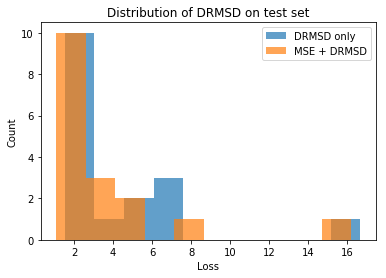

In [155]:
make_2_dist_plot(drmsd_only, mse_drmsd, "DRMSD only", "MSE + DRMSD", filename="drmsd_vs_combined.png")

d1: mean 6.72, std 8.62
d2: mean 6.95, std 16.06


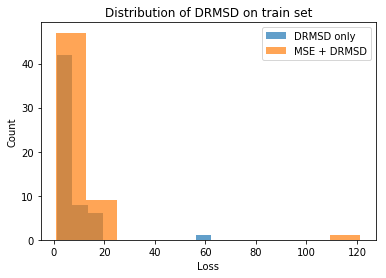

In [156]:
drmsd_only_train = np.load("coords/all_trighelix04_train_drmsd.npy")
mse_drmsd_train = np.load("coords/all_trighelix04_newloss_train_drmsd.npy")
make_2_dist_plot(drmsd_only_train, mse_drmsd_train, "DRMSD only", "MSE + DRMSD", filename="drmsd_vs_combined_train.png", myset="train")

# Plotting loss over training iteration

In [48]:
!pwd

/home/jok120/sml/proj/attention-is-all-you-need-pytorch


In [132]:
def plot_logfile_losses(trainpath, validpath):
    with open(trainpath) as trainlog, \
         open(validpath) as validlog:
        trainlog = trainlog.read().splitlines()
        validlog = validlog.read().splitlines()
        train_vals = np.array([float(x.split(", ")[1]) for x in trainlog[1:]])
        valid_vals = np.array([float(x.split(", ")[1]) for x in validlog[1:]])
        plt.plot(train_vals, label="Train")
        plt.plot(valid_vals, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("MSE+DRMSD Loss")
        min_timestep = np.where(valid_vals == valid_vals.min())[0][0]
        plt.axvline(x=min_timestep, color="black", linestyle="--", label="Minimum validation loss")
        plt.legend()
        plt.title("Model Loss, Trained on ${HardHelices}$")
        plt.savefig("hardhelices_training_loss.png", dpi=300)
        print("Min at", min_timestep)
        


Min at 6


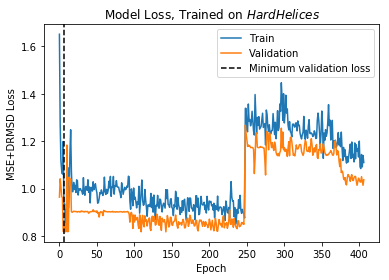

In [133]:
plot_logfile_losses("checkpoints/all_trighelix04_newloss.train.log",
                    "checkpoints/all_trighelix04_newloss.valid.log")

In [64]:
np.where(valid_vals == valid_vals.min())[0][0]

6

In [113]:
def plot_trainlogfile_losses(trainpath, validpath):
    with open(trainpath) as trainlog, \
         open(validpath) as validlog:
        trainlog = trainlog.read().splitlines()
        train_vals = np.array([float(x.strip()) for x in trainlog[1:]])
        train_vals_iternum = np.array(list(range(0,372*100, 100)))
        validlog = validlog.read().splitlines()
        valid_vals = np.array([float(x.split(", ")[1]) for x in validlog[1:]])
        valid_vals_iternum = np.array(list(range(9300, 372*100+1, 9300)))
        print(len(train_vals), len(train_vals_iternum))
        plt.plot(x=valid_vals_iternum, y=valid_vals, label="Validation")
        print(len(valid_vals), len(valid_vals_iternum))
#         plt.plot(x= train_vals_iternum, y=train_vals, label="Train")
        plt.xlabel("Iteration")
        plt.ylabel("DRMSD Loss")
        min_timestep = np.where(train_vals == train_vals.min())[0][0]
        plt.axvline(x=min_timestep, color="black", linestyle="--", label="Minimum train loss")
        plt.legend()
        

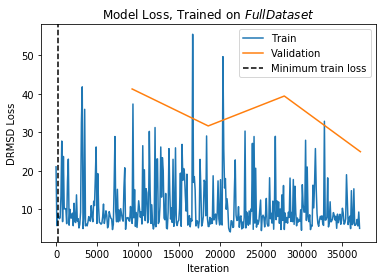

In [129]:
with open("checkpoints/alldata03.train.log") as trainlog, \
     open("checkpoints/alldata03.valid.log") as validlog:
    trainlog = trainlog.read().splitlines()
    train_vals = np.array([float(x.strip()) for x in trainlog[1:]])
    train_vals_iternum = np.array(list(range(0,372*100, 100)))
    validlog = validlog.read().splitlines()
    valid_vals = np.array([float(x.split(", ")[1]) for x in validlog[1:]])
    valid_vals_iternum = np.array(list(range(9300, 372*100+1, 9300)))
    plt.plot(train_vals_iternum, train_vals, label="Train")
    plt.plot(valid_vals_iternum, valid_vals, label="Validation")
    plt.xlabel("Iteration")
    plt.ylabel("DRMSD Loss")
    min_timestep = np.where(train_vals == train_vals.min())[0][0]
    plt.axvline(x=min_timestep, color="black", linestyle="--", label="Minimum train loss")
    plt.legend()
    plt.title("Model Loss, Trained on ${FullDataset}$")
    plt.savefig("fulldataset_training_loss.png", dpi=300)